<h1><center><font size="6">Predicting Financial Distress </font></center></h1>

<h2><center><font size="4">Dataset used:Kaggle </font></center></h2>

In [1]:
# Change the feature engineering to include Polynomial Features 
# Include the Bad column identification & removal from previous week
# Get the Feature Reduction part (Collinear columns & those with low feature importances)

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)
1. [Initialization](#2)
    1. [Load Packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data & Validate](#3)
    
1. [Feature Engineering](#4)
    1. [Prepping - Memory Reduction](#41)
    1. [Feature Generation](#42)
        1. [Custom Mathematical Transformation](#422)
        1. [Polynomial Feature Generation](#422)
    
1. [Feature Reduction](#5)
    1. [Eliminating Duplicates and Constant Columns](#51)
    1. [Collinearity-based Reduction](#52)
    1. [Feature Importance-based Reduction](#53)
    1. [Custom Reduction](#54)

1. [Test Performance](#6)
    1. [Data Prep](#61)
        1. [Train Test Split](#611)
        1. [Resample Train Data](#612)
    1. [Modelling Workflow](#62)
    
1. [Conclusion](#7)
1. [References](#8)

# <a id='1'>Introduction</a>  

We will use a mix of custom functions and polynomial feature generation API to expand the feature space. Then once the synthetic features are created, we will to reduce the feature space by removing collinear columns and filtering further by the top features from the feature importances. Finally we will run the Random Forest Classifier to get test performance on datasets that have been resampled using the technique identified in the previous analysis.


# <a id='2'>Initialization</a>  

### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os
import sys
sys.path.append("/home/paperspace/Kaggle Grandmaster/Udemy Superstar/Classification") 
# Adds higher directory to python modules path.


### <a id='22'>Define Metadata</a>  

In [3]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'SeriousDlqin2yrs'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['No Distress', 'Distress']

input_file_name = 'cs-training.csv'

intermediate_data_path = '../intermediate data/'

# This will be used to compare resampling techniques
clean_df_file_name = intermediate_data_path + 'day2_cleaned_df_output_20200515.csv'

engineered_df_file_name = 'day3_engineered_df_'
output_df_file_name = 'day3_cleaned_df_output_' 

# Enter the date in which this notebook is run
export_date = '20200515'

In [4]:
# Check ou tthe names of the files in the input folder that we need to load as dataframe
print(os.listdir('../intermediate data'))
# This will list all the files in this folder

['.ipynb_checkpoints', 'Archive', 'day1_cleaned_df_output_20200511.pkl', 'day2_cleaned_df_output_20200515.csv']


## <a id='3'>Load Data & Validate</a>  

This time we use the cleaned results from the previous iteration

In [5]:
clean_df = pd.read_csv(clean_df_file_name)
clean_df.sample(5)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
18019,0.491693,37.0,2.0,1.553936,2400.000000,12.0,0.0,2.0,0.0,2.0,0.0,0.0,0
3504,0.031517,46.0,0.0,11.000000,3868.563128,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0
75394,0.904730,59.0,0.0,0.031170,5100.000000,5.0,1.0,0.0,0.0,1.0,0.0,0.0,0
123409,1.000000,33.0,0.0,0.116769,3750.000000,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0
28330,1.000000,24.0,0.0,0.002855,1400.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Lets check the head & tail to make sure there is nothing going on

In [6]:
clean_df.head(3)
# What you are checking here is whether there are some unwanted headers from teh input file that 
# can corrupt our data
# If found, either open the file and manually delete it or only load the relevant columns

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
0,0.000000,29.0,0.0,0.011513,4342.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.595526,55.0,0.0,0.835333,1833.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,0.000000,43.0,0.0,0.043437,4166.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0,0


In [7]:
clean_df.tail(3)
# similar logic here

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,SeriousDlqin2yrs
149997,0.967086,35.0,0.0,0.469314,3600.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0
149998,0.013522,62.0,0.0,0.257847,10098.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0
149999,0.035787,33.0,0.0,0.185247,17500.0,12.0,0.0,2.0,0.0,2.0,0.0,0.0,0


No data corruption seen in either the head or the tail

In [8]:
len(clean_df)

150000

## <a id='4'> Feature Engineering  

### <a id='41'> Prepping

We are going to reduce our memory footprint of the stored dataframe to ease the burden on the processing. Subsequently, we are going to cut down on the number of features we want to apply feature engineering on by using the top features identified by a ML classifier like RandomForestClassifier

#### <a id='411'> Memory Reduction

In [9]:
# Check out what the data types are before the more efficient storage occurs
clean_df.dtypes

RevolvingUtilizationOfUnsecuredLines    float64
age                                     float64
NumberOfTime30-59DaysPastDueNotWorse    float64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans         float64
NumberOfTimes90DaysLate                 float64
NumberRealEstateLoansOrLines            float64
NumberOfTime60-89DaysPastDueNotWorse    float64
NumberOfDependents                      float64
MonthlyIncome_na                        float64
NumberOfDependents_na                   float64
SeriousDlqin2yrs                          int64
dtype: object

In [10]:
%%time
# Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

from helper_functions_comprehensive import reduce_mem_usage_function

clean_df, NA_dict = reduce_mem_usage_function(clean_df)
# There is 2x reduction in the size of the data
# All the float64 got converted to float32

Memory usage of dataframe is 14.88 MB
Column RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column age dtype after is uint8 
******************************
Column NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column DebtRatio dtype after is float32 
******************************
Column MonthlyIncome dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents dtype after is float32 
******************************
Column MonthlyIncome_na dtype after is float32 
******************************
Column NumberOfDepende

###### Split Target Features

In [11]:
X = clean_df.drop(target_class_name, axis=1)
y = clean_df[target_class_name]
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na
0,0.000000,29,0.0,0.011513,4342.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.595527,55,0.0,0.835333,1833.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.000000,43,0.0,0.043437,4166.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0
3,0.391980,40,0.0,0.059771,9000.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0
4,0.000000,35,0.0,0.133598,5800.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0


#### <a id=412 > Selecting top 10 features - Feature Importances

Depending on the resources available, you can go all out and apply feature tools on all the features. But I would recommend just doing it for the top 10 features as defined by the Feature Importances from a simple ML algorithm. Note that since we are not using the fitted model for inferencing, there is no need to do train_test_split. I am going to apply the RandomForestClassifier on the whole dataset

In [12]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state = 42)

# Fit on the input data
classifier.fit(X, y)

# Get the feature importances
feature_importances = classifier.feature_importances_

# Create a dataframe to hold the feature importances
feature_importances_df = pd.DataFrame({'feature': list(X.columns), 
'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances_df.head(10)
# Print from the highest to the lowest feature importance

,feature,importance
0,RevolvingUtilizationOfUnsecuredLines,0.188549
3,DebtRatio,0.168443
4,MonthlyIncome,0.163312
1,age,0.121962
5,NumberOfOpenCreditLinesAndLoans,0.086971
6,NumberOfTimes90DaysLate,0.085577
2,NumberOfTime30-59DaysPastDueNotWorse,0.053070
8,NumberOfTime60-89DaysPastDueNotWorse,0.047035
9,NumberOfDependents,0.043132
7,NumberRealEstateLoansOrLines,0.033151


In [13]:
imp_column_list = list(feature_importances_df.head(10)['feature'].values)
imp_column_list
# Now use these moving forward for the automated feature engineering

['RevolvingUtilizationOfUnsecuredLines',
 'DebtRatio',
 'MonthlyIncome',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents',
 'NumberRealEstateLoansOrLines']

In [14]:
imp_X = X[imp_column_list].copy()
unimp_X = X[list(set(X.columns) - set(imp_column_list))].copy()
# the latter will be later used to concatenate with the engineered features before feature reduction

assert((len(imp_X.columns) + len(unimp_X.columns)) ==  len(X.columns))

len(imp_X.columns), len(unimp_X.columns), len(X.columns)


(10, 2, 12)

### <a id=42 >Feature Generation

Feature Engineering can based on domain knowledge or clever intuition based on the understanding of the data. But given that this is a Kaggle dataset we cant do either, the next best option is to do combinations of features using mathematical operations which is what we are going to attempt here.

#### <a id=421 > Custom Mathematical Feature Generation

In [15]:
# create a copy of the dataframe that will be holding our engineered variables
engineered_df = imp_X.copy()
engineered_df.head()

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,age,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,NumberRealEstateLoansOrLines
0,0.000000,0.011513,4342.0,29,5.0,0.0,0.0,0.0,0.0,0.0
1,0.595527,0.835333,1833.0,55,11.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.043437,4166.0,43,2.0,0.0,0.0,0.0,4.0,0.0
3,0.391980,0.059771,9000.0,40,2.0,0.0,0.0,0.0,5.0,0.0
4,0.000000,0.133598,5800.0,35,12.0,0.0,0.0,0.0,0.0,1.0


In [16]:
%%time

numerical_col_list = list(engineered_df.select_dtypes('number').columns)

# Only apply the transformations on continuous features
for col in numerical_col_list:
    print(col)
    
    engineered_df['square_' + col] = engineered_df[col].apply(lambda x: x*x)

    min_val = engineered_df[col].min()
    # Apply log transformation while ensuring no NaNs are generated
    engineered_df['log_' + col] = engineered_df[col].apply(lambda x: np.log(x-min_val+1))
    
    # Similarly, subtract the min to make sure that the sqrt is always positive
    engineered_df['sqrt_' + col] = engineered_df[col].apply(lambda x: np.sqrt(x-min_val))
        
    # If else function for the reciprocal to work correctly
    engineered_df['reciproc_' + col] = engineered_df[col].apply(lambda x: 1./x if np.abs(x) else 0)
    
print('No. of columns now are {}'.format(len(engineered_df.columns)))

# The number of columns makes sense because 3 original columns *4 operations = 12 new columns

RevolvingUtilizationOfUnsecuredLines
DebtRatio
MonthlyIncome
age
NumberOfOpenCreditLinesAndLoans
NumberOfTimes90DaysLate
NumberOfTime30-59DaysPastDueNotWorse
NumberOfTime60-89DaysPastDueNotWorse
NumberOfDependents
NumberRealEstateLoansOrLines
No. of columns now are 50
CPU times: user 22.1 s, sys: 224 ms, total: 22.4 s
Wall time: 21.3 s


In [17]:
engineered_df.head()
# Notice how the additional features are appended at the end

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,age,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,NumberRealEstateLoansOrLines,...,sqrt_NumberOfTime60-89DaysPastDueNotWorse,reciproc_NumberOfTime60-89DaysPastDueNotWorse,square_NumberOfDependents,log_NumberOfDependents,sqrt_NumberOfDependents,reciproc_NumberOfDependents,square_NumberRealEstateLoansOrLines,log_NumberRealEstateLoansOrLines,sqrt_NumberRealEstateLoansOrLines,reciproc_NumberRealEstateLoansOrLines
0,0.000000,0.011513,4342.0,29,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.504502,0.810037,0.00,0.0,0.000000,0.0,0.0
1,0.595527,0.835333,1833.0,55,11.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.504502,0.810037,0.00,1.0,0.693147,1.0,1.0
2,0.000000,0.043437,4166.0,43,2.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,16.0,1.732745,2.157814,0.25,0.0,0.000000,0.0,0.0
3,0.391980,0.059771,9000.0,40,2.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,25.0,1.895543,2.378268,0.20,0.0,0.000000,0.0,0.0
4,0.000000,0.133598,5800.0,35,12.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.504502,0.810037,0.00,1.0,0.693147,1.0,1.0


#### <a id=422 > Polynomial Feature Generation

sklearn has a good package called Polynomial Features which is good at generating cross terms

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

How does this work? Basically, the method creates all possible cross terms upto the polynomial degree passed in as a parameter

In [18]:
# This hack is to make the Polynomial cross terms only work on the continuous features 
# as opposed to all the other features in the engineered_df (which may have Object columns too)

# This line assumes that the recently engineered features occur at the end
new_math_col_list = list(engineered_df.columns[-(len(numerical_col_list)*4):])
new_math_col_list

['square_RevolvingUtilizationOfUnsecuredLines',
 'log_RevolvingUtilizationOfUnsecuredLines',
 'sqrt_RevolvingUtilizationOfUnsecuredLines',
 'reciproc_RevolvingUtilizationOfUnsecuredLines',
 'square_DebtRatio',
 'log_DebtRatio',
 'sqrt_DebtRatio',
 'reciproc_DebtRatio',
 'square_MonthlyIncome',
 'log_MonthlyIncome',
 'sqrt_MonthlyIncome',
 'reciproc_MonthlyIncome',
 'square_age',
 'log_age',
 'sqrt_age',
 'reciproc_age',
 'square_NumberOfOpenCreditLinesAndLoans',
 'log_NumberOfOpenCreditLinesAndLoans',
 'sqrt_NumberOfOpenCreditLinesAndLoans',
 'reciproc_NumberOfOpenCreditLinesAndLoans',
 'square_NumberOfTimes90DaysLate',
 'log_NumberOfTimes90DaysLate',
 'sqrt_NumberOfTimes90DaysLate',
 'reciproc_NumberOfTimes90DaysLate',
 'square_NumberOfTime30-59DaysPastDueNotWorse',
 'log_NumberOfTime30-59DaysPastDueNotWorse',
 'sqrt_NumberOfTime30-59DaysPastDueNotWorse',
 'reciproc_NumberOfTime30-59DaysPastDueNotWorse',
 'square_NumberOfTime60-89DaysPastDueNotWorse',
 'log_NumberOfTime60-89DaysPastDu

In [19]:
%%time
from sklearn.preprocessing import PolynomialFeatures

poly_object = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
# Note that I have changed the include_bias to False, otherwise it creates a column of 1s

# I am applying the fit_transform method on only the continuous non-object columns
poly_df = pd.DataFrame(poly_object.fit_transform(engineered_df[numerical_col_list +new_math_col_list]),
                       columns = list(poly_object.get_feature_names(
                       engineered_df[numerical_col_list+new_math_col_list].columns)),
                       index=engineered_df.index)

# How do you figure out the number of new columns being generated?
# https://math.stackexchange.com/questions/1424824/general-formula-for-number-of-terms-in-an-expansion

CPU times: user 2.88 s, sys: 840 ms, total: 3.72 s
Wall time: 3.71 s


In [20]:
poly_df.head()
# you start seeing both square terms as well as cross-terms between the variables

,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,age,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,NumberRealEstateLoansOrLines,...,reciproc_NumberOfDependents square_NumberRealEstateLoansOrLines,reciproc_NumberOfDependents log_NumberRealEstateLoansOrLines,reciproc_NumberOfDependents sqrt_NumberRealEstateLoansOrLines,reciproc_NumberOfDependents reciproc_NumberRealEstateLoansOrLines,square_NumberRealEstateLoansOrLines log_NumberRealEstateLoansOrLines,square_NumberRealEstateLoansOrLines sqrt_NumberRealEstateLoansOrLines,square_NumberRealEstateLoansOrLines reciproc_NumberRealEstateLoansOrLines,log_NumberRealEstateLoansOrLines sqrt_NumberRealEstateLoansOrLines,log_NumberRealEstateLoansOrLines reciproc_NumberRealEstateLoansOrLines,sqrt_NumberRealEstateLoansOrLines reciproc_NumberRealEstateLoansOrLines
0,0.000000,0.011513,4342.0,29.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.595527,0.835333,1833.0,55.0,11.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.693147,1.0,1.0,0.693147,0.693147,1.0
2,0.000000,0.043437,4166.0,43.0,2.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,0.391980,0.059771,9000.0,40.0,2.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.000000,0.133598,5800.0,35.0,12.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.693147,1.0,1.0,0.693147,0.693147,1.0


In [21]:
# combine the above poly_df with the discrete part of engineered_df

object_col_list = list(set(imp_X.columns) - set(numerical_col_list))
print(len(object_col_list))

engineered_df = pd.concat([engineered_df[object_col_list], poly_df], axis=1)

# As expected the length of the object columns is 0 because all of these are going to be numerical ones

0


In [22]:
print('There are currently {} columns'.format(len(engineered_df.columns)))
# Note some redundant columns will be generated because we took the square of some square root terms from before   

There are currently 1275 columns


##### Reduce Memory

In [23]:
%%time
# Lets try reducing the memory footprint
features, NAlist = reduce_mem_usage_function(engineered_df)

Memory usage of dataframe is 1459.12 MB
Column RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column DebtRatio dtype after is float32 
******************************
Column MonthlyIncome dtype after is float32 
******************************
Column age dtype after is uint8 
******************************
Column NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents dtype after is float32 
******************************
Column NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
************************

Column RevolvingUtilizationOfUnsecuredLines log_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column RevolvingUtilizationOfUnsecuredLines sqrt_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column RevolvingUtilizationOfUnsecuredLines reciproc_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column RevolvingUtilizationOfUnsecuredLines square_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column RevolvingUtilizationOfUnsecuredLines log_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column RevolvingUtilizationOfUnsecuredLines sqrt_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column RevolvingUtilizationOfUnsecuredLines reciproc_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column RevolvingUtilizationOfUnsecuredLines 

Column MonthlyIncome log_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column MonthlyIncome sqrt_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column MonthlyIncome reciproc_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column MonthlyIncome square_DebtRatio dtype after is float32 
******************************
Column MonthlyIncome log_DebtRatio dtype after is float32 
******************************
Column MonthlyIncome sqrt_DebtRatio dtype after is float32 
******************************
Column MonthlyIncome reciproc_DebtRatio dtype after is float32 
******************************
Column MonthlyIncome square_MonthlyIncome dtype after is float32 
******************************
Column MonthlyIncome log_MonthlyIncome dtype after is float32 
******************************
Column MonthlyIncome sqrt_MonthlyIncome dtype after is float32 
*******************

Column age log_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column age sqrt_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column age reciproc_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans NumberOfDependents dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column NumberOfOpenCreditLinesAndLoans square_RevolvingUtilizationOfUnsecuredLine

Column NumberOfTimes90DaysLate log_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column NumberOfTimes90DaysLate sqrt_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column NumberOfTimes90DaysLate reciproc_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column NumberOfTimes90DaysLate square_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberOfTimes90DaysLate log_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberOfTimes90DaysLate sqrt_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberOfTimes90DaysLate reciproc_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column NumberOfTimes90DaysLate square_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfTimes90DaysLate lo

Column NumberOfTime30-59DaysPastDueNotWorse reciproc_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse NumberOfDependents dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse square_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse log_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse sqrt_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse reciproc_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column NumberOfTime60-89DaysPastDueNotWorse squa

Column NumberOfDependents square_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents log_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents sqrt_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents reciproc_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents square_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents log_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents sqrt_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column NumberOfDependents reciproc_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column

Column square_RevolvingUtilizationOfUnsecuredLines log_age dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines sqrt_age dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines reciproc_age dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines square_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines log_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines sqrt_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines reciproc_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column square_RevolvingUtilizationOfUnsecuredLines square_NumberOfTimes90Da

Column log_RevolvingUtilizationOfUnsecuredLines square_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column log_RevolvingUtilizationOfUnsecuredLines log_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column log_RevolvingUtilizationOfUnsecuredLines sqrt_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column log_RevolvingUtilizationOfUnsecuredLines reciproc_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column sqrt_RevolvingUtilizationOfUnsecuredLines reciproc_RevolvingUtilizationOfUnsecuredLines dtype after is float32 
******************************
Column sqrt_RevolvingUtilizationOfUnsecuredLines square_DebtRatio dtype after is float32 
******************************
Column sqrt_RevolvingUtilizationOfUnsecuredLines log_DebtRatio dtype after is float32 
******************************
Column sqrt_RevolvingUtilizationOfUnsecuredLines sqrt_Debt

Column reciproc_RevolvingUtilizationOfUnsecuredLines log_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column reciproc_RevolvingUtilizationOfUnsecuredLines sqrt_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column reciproc_RevolvingUtilizationOfUnsecuredLines reciproc_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column reciproc_RevolvingUtilizationOfUnsecuredLines square_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column reciproc_RevolvingUtilizationOfUnsecuredLines log_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column reciproc_RevolvingUtilizationOfUnsecuredLines sqrt_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column reciproc_RevolvingUtilizationOfUnsecuredLines reciproc_NumberOfTime60-89DaysPastDueNotWor

Column log_DebtRatio square_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column log_DebtRatio log_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column log_DebtRatio sqrt_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column log_DebtRatio reciproc_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column log_DebtRatio square_NumberOfDependents dtype after is float32 
******************************
Column log_DebtRatio log_NumberOfDependents dtype after is float32 
******************************
Column log_DebtRatio sqrt_NumberOfDependents dtype after is float32 
******************************
Column log_DebtRatio reciproc_NumberOfDependents dtype after is float32 
******************************
Column log_DebtRatio square_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column

Column reciproc_DebtRatio sqrt_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column reciproc_DebtRatio reciproc_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column square_MonthlyIncome log_MonthlyIncome dtype after is float32 
******************************
Column square_MonthlyIncome sqrt_MonthlyIncome dtype after is float32 
******************************
Column square_MonthlyIncome reciproc_MonthlyIncome dtype after is float32 
******************************
Column square_MonthlyIncome square_age dtype after is float32 
******************************
Column square_MonthlyIncome log_age dtype after is float32 
******************************
Column square_MonthlyIncome sqrt_age dtype after is float32 
******************************
Column square_MonthlyIncome reciproc_age dtype after is float32 
******************************
Column square_MonthlyIncome square_NumberOfOpenCreditLinesAndLoans dtype after is fl

Column sqrt_MonthlyIncome sqrt_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column sqrt_MonthlyIncome reciproc_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column sqrt_MonthlyIncome square_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_MonthlyIncome log_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_MonthlyIncome sqrt_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_MonthlyIncome reciproc_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_MonthlyIncome square_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_MonthlyIncome log_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_MonthlyIncome sqrt_N

Column log_age sqrt_age dtype after is uint8 
******************************
Column log_age reciproc_age dtype after is float32 
******************************
Column log_age square_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column log_age log_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column log_age sqrt_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column log_age reciproc_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column log_age square_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column log_age log_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column log_age sqrt_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column log_age reciproc_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column

Column square_NumberOfOpenCreditLinesAndLoans reciproc_NumberOfOpenCreditLinesAndLoans dtype after is float32 
******************************
Column square_NumberOfOpenCreditLinesAndLoans square_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column square_NumberOfOpenCreditLinesAndLoans log_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column square_NumberOfOpenCreditLinesAndLoans sqrt_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column square_NumberOfOpenCreditLinesAndLoans reciproc_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column square_NumberOfOpenCreditLinesAndLoans square_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column square_NumberOfOpenCreditLinesAndLoans log_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column square_NumberOfOpenCreditLinesAndLoans 

Column sqrt_NumberOfOpenCreditLinesAndLoans log_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column sqrt_NumberOfOpenCreditLinesAndLoans sqrt_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column sqrt_NumberOfOpenCreditLinesAndLoans reciproc_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column reciproc_NumberOfOpenCreditLinesAndLoans square_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column reciproc_NumberOfOpenCreditLinesAndLoans log_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column reciproc_NumberOfOpenCreditLinesAndLoans sqrt_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column reciproc_NumberOfOpenCreditLinesAndLoans reciproc_NumberOfTimes90DaysLate dtype after is float32 
******************************
Column reciproc_NumberOfOpenCreditLinesAndLoans square_NumberOfTi

Column sqrt_NumberOfTimes90DaysLate sqrt_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTimes90DaysLate reciproc_NumberOfTime30-59DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTimes90DaysLate square_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTimes90DaysLate log_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTimes90DaysLate sqrt_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTimes90DaysLate reciproc_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTimes90DaysLate square_NumberOfDependents dtype after is float32 
******************************
Column sqrt_NumberOfTimes90DaysLate log_NumberOfDependents dtype after is fl

Column sqrt_NumberOfTime30-59DaysPastDueNotWorse log_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTime30-59DaysPastDueNotWorse sqrt_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTime30-59DaysPastDueNotWorse reciproc_NumberOfTime60-89DaysPastDueNotWorse dtype after is float32 
******************************
Column sqrt_NumberOfTime30-59DaysPastDueNotWorse square_NumberOfDependents dtype after is float32 
******************************
Column sqrt_NumberOfTime30-59DaysPastDueNotWorse log_NumberOfDependents dtype after is float32 
******************************
Column sqrt_NumberOfTime30-59DaysPastDueNotWorse sqrt_NumberOfDependents dtype after is float32 
******************************
Column sqrt_NumberOfTime30-59DaysPastDueNotWorse reciproc_NumberOfDependents dtype after is float32 
******************************
Column sqrt_NumberOfTime30-59DaysPastDueNo

Column reciproc_NumberOfTime60-89DaysPastDueNotWorse reciproc_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column square_NumberOfDependents log_NumberOfDependents dtype after is float32 
******************************
Column square_NumberOfDependents sqrt_NumberOfDependents dtype after is float32 
******************************
Column square_NumberOfDependents reciproc_NumberOfDependents dtype after is float32 
******************************
Column square_NumberOfDependents square_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column square_NumberOfDependents log_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column square_NumberOfDependents sqrt_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column square_NumberOfDependents reciproc_NumberRealEstateLoansOrLines dtype after is float32 
******************************
Column log_NumberOfDep

Now lets combine with the rest of the unimportant features

Why are you combining the previously identified low important features if you know that you will be dropping a significant number of features further down the code?

Because the old unimportant features may actually  be higher ranked than some of the newer synthetic features

In [25]:
len(engineered_df.columns)

1275

In [26]:
engineered_df = pd.concat([engineered_df, unimp_X], axis=1)
engineered_df.head()
print(len(engineered_df.columns))

1277


## <a id='5'> Feature Reduction  

### <a id='51'> Identify & Remove Constant or Duplicate Columns  

For our dataset, its highly unlikely we have duplicate columns because they are not categorical. But there are cross terms like sq() of sqrt() which will give you back the original feature

In [27]:
engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Columns: 1277 entries, RevolvingUtilizationOfUnsecuredLines to NumberOfDependents_na
dtypes: float32(1250), uint16(13), uint32(5), uint8(9)
memory usage: 723.1 MB


In [28]:
%%time

from helper_functions_comprehensive import find_bad_columns_function

null_col_list, blank_space_col_list, constant_numeric_col_list, \
constant_non_numeric_col_list, duplicate_col_list = find_bad_columns_function(engineered_df)

print('Before dropping irrelevant features and duplicated columns,')
print('{} number of columns were present'.format(len(engineered_df.columns)))

Identified 0 features with atleast one null
Identified 0 features with atleast one blank space
Identified 12 numeric features that have quasi-constant values
Identified 0 non-numeric features that have quasi-constant values
Identified 9 features that are duplicates of other features
Before dropping irrelevant features and duplicated columns,
1277 number of columns were present
CPU times: user 6min 2s, sys: 4.08 s, total: 6min 6s
Wall time: 5min 52s


In [29]:
%%time

already_dropped_col_set = set()
for drop_column_list in [null_col_list, constant_numeric_col_list, 
                         constant_non_numeric_col_list, duplicate_col_list]:
    
    # This is just to prevent error messages
    to_drop_set = set(drop_column_list) - already_dropped_col_set
    
    # Drop the above but only those that have not already been dropped     
    features.drop(to_drop_set, axis=1, inplace=True)
    
    #### Store the deleted columns
    already_dropped_col_set.update(to_drop_set)

print('After dropping the above, ')
print('{} number of columns are present'.format(len(features.columns)))


After dropping the above, 
1254 number of columns are present
CPU times: user 3.91 s, sys: 2.31 s, total: 6.22 s
Wall time: 1.36 s


### <a id='52'> Identify & Remove Collinear Features  

Collinear variables are those which are highly correlated with one another. These can decrease the model's ability to learn, model interpretability, and generalization performance on the test set. 
What criteria should we use to remove them once identified? We will take features having more than 0.8 collinearity with another variable

Some source code is adapted from Chris Albon and Will Koehrsen

https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [30]:
%%time

# Threshold for removing correlated variables. This is arbitrary and can itself be a hyperparam
collinearity_threshold = 0.80

# Absolute value correlation matrix. 
# The default in Pearson but you should use Spearman for Ordinal categoricals
corr_matrix_df = engineered_df.corr().abs()

# Upper triangle of correlations
# np.triu returns a matrix with elements below the kth diagonal zeroed

# Create a mask with the above and store just the upper triangular values 
# Because they are the only useful ones anyway

upper_df = corr_matrix_df.where(np.triu(np.ones(corr_matrix_df.shape), k=1).astype(np.bool))
upper_df.head()

CPU times: user 7min 34s, sys: 756 ms, total: 7min 35s
Wall time: 7min 34s


In [31]:
%%time
# Select columns with correlations above 80% threshold
collinear_columns_list = [column for column in upper_df.columns 
                          if any(upper_df[column] > collinearity_threshold)]

print('There are {} columns to remove'.format(len(collinear_columns_list)))

There are 1109 columns to remove
CPU times: user 380 ms, sys: 0 ns, total: 380 ms
Wall time: 381 ms


##### Drop the columns

In [32]:
engineered_df = engineered_df.drop(columns = collinear_columns_list)

print('Features shape: ', engineered_df.shape)

Features shape:  (150000, 168)


### <a id='53'> Identify & remove low important features

lets use a simple classifier like Random Forest to figure out the top features

In [33]:
%%time
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(engineered_df, y)

# Record the feature importances
feature_importances = classifier.feature_importances_

feature_importances_df = pd.DataFrame({'feature': list(engineered_df.columns), 
'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances_df.head()
# Print from the highest to the lowest

CPU times: user 1min 52s, sys: 60 ms, total: 1min 52s
Wall time: 1min 52s


In [34]:
# Find the features with zero importance
zero_features_list = list(feature_importances_df[
                        feature_importances_df['importance'] == 0.000]['feature'])
print('There are {} features with 0 importance'.format(len(zero_features_list)))
feature_importances_df.tail()

There are 1 features with 0 importance


,feature,importance
29,RevolvingUtilizationOfUnsecuredLines reciproc_...,0.000068
49,MonthlyIncome reciproc_MonthlyIncome,0.000067
41,DebtRatio reciproc_DebtRatio,0.000065
12,log_MonthlyIncome,0.000015
56,age reciproc_age,0.000000


Depending on the problem we can choose to remove just those features with 0 importance or formally establish a threshold for identify and drop those with low feature importance

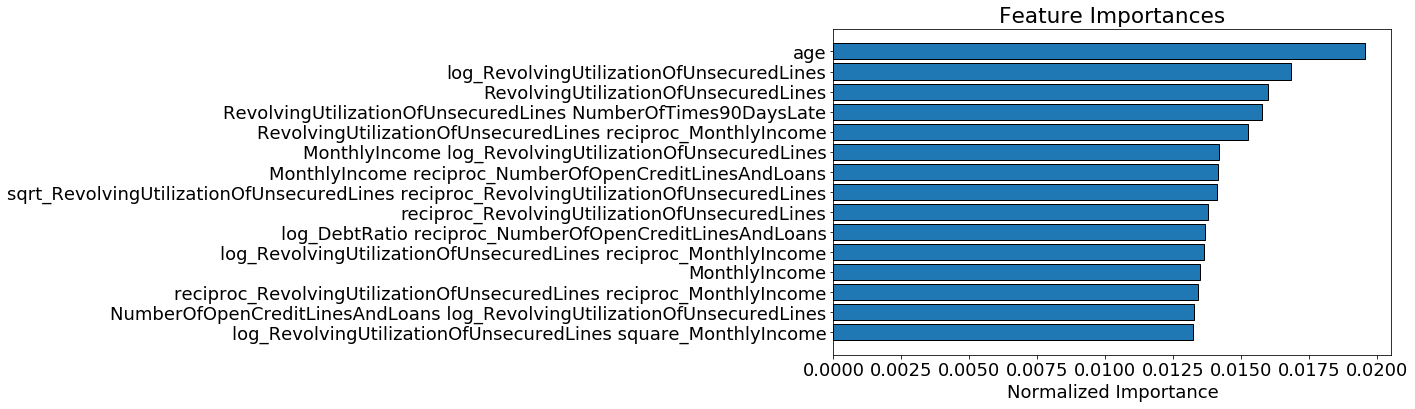

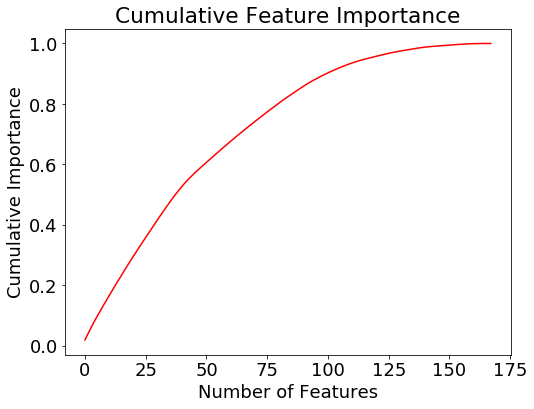

101 features required for 0.9 of cumulative importance


In [35]:
from helper_functions_comprehensive import plot_feature_importances
norm_feature_importances_df, no_of_important_col = plot_feature_importances(feature_importances_df, threshold = 0.90)

In [36]:
norm_feature_importances_df.head()
# Notice how some of the engineered features are supposedly better than the original features

,index,feature,importance,importance_normalized,cumulative_importance
0,3,age,0.019565,0.019565,0.019565
1,8,log_RevolvingUtilizationOfUnsecuredLines,0.016860,0.016860,0.036426
2,0,RevolvingUtilizationOfUnsecuredLines,0.015990,0.015990,0.052415
3,25,RevolvingUtilizationOfUnsecuredLines NumberOfT...,0.015763,0.015763,0.068178
4,32,RevolvingUtilizationOfUnsecuredLines reciproc_...,0.015262,0.015262,0.083440


In [37]:
# Lets use no_of_important_col as the row index to get the names of the features 
relevant_feature_list = (norm_feature_importances_df['feature'].values)[:no_of_important_col]

In [38]:
import pickle
# This will export the engineered_df 
pickle.dump(engineered_df, open(engineered_df_file_name + export_date + '.pkl', 'wb'))

In [39]:
#Keep these highest importance features
engineered_df = engineered_df[relevant_feature_list].copy()
engineered_df.shape

(150000, 101)

In [40]:
engineered_df.head()

,age,log_RevolvingUtilizationOfUnsecuredLines,RevolvingUtilizationOfUnsecuredLines,RevolvingUtilizationOfUnsecuredLines NumberOfTimes90DaysLate,RevolvingUtilizationOfUnsecuredLines reciproc_MonthlyIncome,MonthlyIncome log_RevolvingUtilizationOfUnsecuredLines,MonthlyIncome reciproc_NumberOfOpenCreditLinesAndLoans,sqrt_RevolvingUtilizationOfUnsecuredLines reciproc_RevolvingUtilizationOfUnsecuredLines,reciproc_RevolvingUtilizationOfUnsecuredLines,log_DebtRatio reciproc_NumberOfOpenCreditLinesAndLoans,...,MonthlyIncome log_NumberOfTime60-89DaysPastDueNotWorse,NumberRealEstateLoansOrLines reciproc_NumberOfOpenCreditLinesAndLoans,NumberOfDependents reciproc_NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,reciproc_MonthlyIncome reciproc_NumberOfTime60-89DaysPastDueNotWorse,DebtRatio NumberOfTime60-89DaysPastDueNotWorse,reciproc_NumberOfTimes90DaysLate reciproc_NumberOfTime30-59DaysPastDueNotWorse,reciproc_NumberOfOpenCreditLinesAndLoans log_NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse square_DebtRatio,DebtRatio square_NumberOfTimes90DaysLate
0,29,0.000000,0.000000,0.0,0.000000,0.000000,868.400024,0.000000,0.000000,0.002289,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55,0.467204,0.595527,0.0,0.000325,856.384521,166.636368,1.295834,1.679186,0.055202,...,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,43,0.000000,0.000000,0.0,0.000000,0.000000,2083.000000,0.000000,0.000000,0.021260,...,0.0,0.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,0.330727,0.391980,0.0,0.000044,2976.544189,4500.000000,1.597232,2.551151,0.029026,...,0.0,0.000000,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35,0.000000,0.000000,0.0,0.000000,0.000000,483.333344,0.000000,0.000000,0.010450,...,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### <a id = 54> Custom Feature Removal

In [41]:
no_of_feature_cutoff = 30

# The first priority should be the original set of features that are also present in our top 150 from above
final_feature_list = [col for col in relevant_feature_list if col in imp_column_list]

# Only look to add the remaining features that were not in the original top columns list
for i, col in enumerate(relevant_feature_list):
    final_feature_list.append(col)
    print(col)
    if len(final_feature_list)==no_of_feature_cutoff:
        break

age
log_RevolvingUtilizationOfUnsecuredLines
RevolvingUtilizationOfUnsecuredLines
RevolvingUtilizationOfUnsecuredLines NumberOfTimes90DaysLate
RevolvingUtilizationOfUnsecuredLines reciproc_MonthlyIncome
MonthlyIncome log_RevolvingUtilizationOfUnsecuredLines
MonthlyIncome reciproc_NumberOfOpenCreditLinesAndLoans
sqrt_RevolvingUtilizationOfUnsecuredLines reciproc_RevolvingUtilizationOfUnsecuredLines
reciproc_RevolvingUtilizationOfUnsecuredLines
log_DebtRatio reciproc_NumberOfOpenCreditLinesAndLoans
log_RevolvingUtilizationOfUnsecuredLines reciproc_MonthlyIncome
MonthlyIncome
reciproc_RevolvingUtilizationOfUnsecuredLines reciproc_MonthlyIncome
NumberOfOpenCreditLinesAndLoans log_RevolvingUtilizationOfUnsecuredLines
log_RevolvingUtilizationOfUnsecuredLines square_MonthlyIncome
sqrt_RevolvingUtilizationOfUnsecuredLines log_NumberOfTimes90DaysLate
reciproc_MonthlyIncome
reciproc_DebtRatio reciproc_NumberOfOpenCreditLinesAndLoans
RevolvingUtilizationOfUnsecuredLines reciproc_NumberOfOpenCredi

## <a id='6'>Test Performance</a> 

### <a id='61'>Data Prep</a> 

#### <a id='611'>Train Test Split</a> 

In [42]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(engineered_df[relevant_feature_list[:25]], 
                                                    y, test_size=0.2, random_state=42)

#### <a id='612'>Resample Training Data

In [43]:
# Generate the resampled data using one of the imblearn methods
from imblearn.combine import SMOTEENN

X_resampled_train, y_resampled_train = SMOTEENN(sampling_strategy='all', 
                                                random_state=42).fit_sample(X_train, y_train)
print(X_resampled_train.shape,sum(y_resampled_train))

(146941, 25) 79631.0


### <a id='62'>Modelling Workflow</a> 

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a classifier object with default params
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_resampled_train, y_resampled_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Has a Test accuracy of 85.0 % 
              precision    recall  f1-score   support

 No Distress       0.96      0.87      0.91     27966
    Distress       0.23      0.52      0.32      2034

    accuracy                           0.85     30000
   macro avg       0.59      0.69      0.61     30000
weighted avg       0.91      0.85      0.87     30000

The ROC AUC Score on Test set is 0.8
Confusion matrix, without normalization
[[24386  3580]
 [  984  1050]]


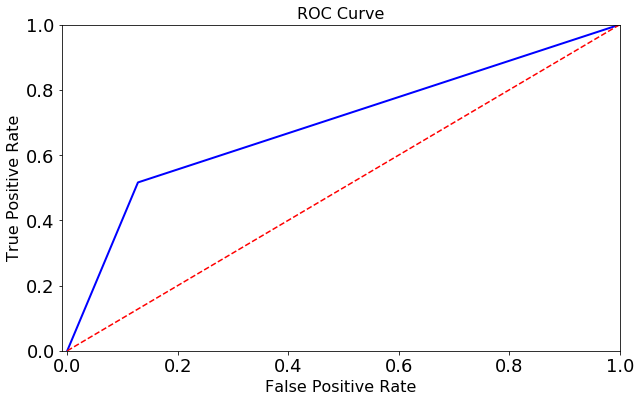

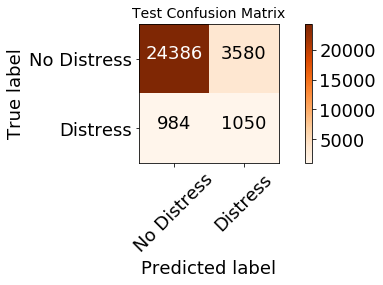

In [45]:
from helper_functions_comprehensive import custom_classification_metrics_function
custom_classification_metrics_function(X_test, y_test, labels, classifier, data_type='Test')

In [46]:
from helper_functions_comprehensive import precision_at_recall_threshold_function

predicted_proba = classifier.predict_proba(X_test)[:,1]
threshold_precision = precision_at_recall_threshold_function(
                        y_test, predicted_proba, recall_threshold=0.85)

# For comparison, lets print the precision at the recall threshold of 85%
print(threshold_precision)

0.12204585537918872


In [47]:
# The test metric is worse than Day2 (most likely because the new features introduce noise)

## <a id=7 > Conclusion

I am going to go back to the exported data in Day2 rather than the featured engineered dataframe here

## <a id=8 > References

sklearn documentation on Polynomial Feature Generation
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Examples on stackoverflow in using this 
https://stackoverflow.com/questions/36728287/sklearn-preprocessing-polynomialfeatures-how-to-keep-column-names-headers-of

Removing collinear features
https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

https://docs.scipy.org/doc/numpy/reference/generated/numpy.triu.html


In [ ]:
# In week 4, we will be starting again from the exported data from week 2 and try hyperparam tuning